## Compute across-track geostrophic velocities from Sentinel-6 or Jason-3 ##

<br>made for Eumetsat Copernicus Marine Data Service by V. Rosmorduc, CLS

** Import libraries **



In [1]:
import os
import numpy as np
# reading / using NetCDF data
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20) #define the size of the figures 
import cartopy                  # Import the mapping library (note: this is needed to deal with mapping projections)
import cartopy.crs as ccrs      #  Define the namespace for the geographical projections

input_root = 'data/'
input_path = ''

In [2]:
#Alboran sea: track 20, 111, 96 + a bit east 172+187
#input_file = 'S6A_P4_2__LR_RED__ST_052_111_20220411T155943_20220411T165555_F05.nc'
#Alboran Sea
#lon_min=360-6 ; lon_max=360-0 ; lat_min=35 ; lat_max=38
#hmin = -0.15 ; hmax = 0.15

# Agulhas 
input_file = 'S6A_P4_2__HR_RED__NT_047_107_20220220T222213_20220220T231826_F05.nc'
#area limits
lon_min=15 ; lon_max=30 ; lat_min=-45 ; lat_max=-30
# reasonable SLA min/max in the area.
hmin = -0.5 ; hmax = 0.5

#gulfStream
#input_file = 'S6A_P4_2__HR_RED__NT_047_115_20220221T055156_20220221T064809_F05.nc'
#lon_min=360-65 ; lon_max=360-55 ; lat_min=35 ; lat_max=45
# reasonable SLA min/max in the area.
#hmin = -0.5 ; hmax = 0.5

#open S6 file - you will be using two different groups.
altifile = os.path.join(input_root,input_path,input_file)
nc01 = xr.open_dataset(altifile, group='data_01')
nc01ku = xr.open_dataset(altifile, group='data_01/ku')

** define alti variables **<br>


In [3]:
#latitude, longitude at 1 Hz
latalti = nc01['latitude']
lonalti = nc01['longitude']
# track direction : 0 -> descending 1-> ascending
# It has the same value over the whole track. So there's not much point keeping an array for it -- !!! TBC for NRT files !!!
track_direction = nc01['pass_direction_flag'].data[0]

#SSH anomalies, in the Ku group
ssha = nc01ku['ssha']

## applying quality flag
#slaqual = slaj30[ ncj301ku['range_ocean_qual'] == 0.0 ]
#latqual = latj30[ ncj301ku['range_ocean_qual'] == 0.0 ]
#lonqual = lonj30[ ncj301ku['range_ocean_qual'] == 0.0 ]

We have two different datasets for S6 data: one with lon & lat, the other with SSHA. It is not a problem if you just want to plot SSHA on a map (index values are the same), but to go further we need to associate them. We combine the lat/lon variable with ssha in the same dataset, so as to be able to use conditions to geographically extract, and then also to compute derivatives with respect to spatial coordinates. 

In [4]:
# merge the lon, lat and the ssha variable in the same dataset
ds = xr.Dataset({'ssha01': (['time'],  ssha.data)}, coords={'lon01': (['time'], lonalti.data), 'lat01': (['time'], latalti.data)})
nc01.close()
nc01ku.close()
#extract only the area of interest. We will use only this dataset after.
extr = ds.sel(time=( ds.lon01 > lon_min) & (ds.lon01 < lon_max) & (ds.lat01 > lat_min) & (ds.lat01 < lat_max))
slaextr = extr['ssha01']
lonextr = extr['lon01']
latextr = extr['lat01']

<xarray.DataArray 'ssha01' (time: 327)>
array([ 1.378e-01,  1.457e-01,  9.100e-02,  1.180e-01,  1.048e-01,
        1.073e-01,  1.057e-01,  1.149e-01,  1.035e-01,  1.006e-01,
        1.069e-01,  1.058e-01,  8.140e-02,  9.290e-02,  7.330e-02,
        8.430e-02,  6.950e-02,  6.130e-02,  6.820e-02,  4.530e-02,
        5.070e-02,  5.420e-02,  3.460e-02,  1.670e-02,  2.990e-02,
        2.690e-02,  8.200e-03, -1.280e-02,  1.150e-02, -1.310e-02,
        0.000e+00, -1.250e-02,  2.800e-03,  3.600e-03, -1.600e-03,
        1.950e-02, -1.000e-03,  1.660e-02,  9.200e-03, -2.020e-02,
        7.500e-03,  0.000e+00, -1.200e-03, -5.500e-03,  5.300e-03,
       -3.290e-02, -3.720e-02, -2.600e-02, -6.500e-03, -9.500e-03,
       -1.940e-02, -4.900e-03, -9.100e-03, -2.000e-04, -7.000e-04,
       -1.000e-03,  4.000e-03, -1.550e-02, -1.400e-02, -1.950e-02,
       -4.980e-02, -3.740e-02, -7.400e-02, -5.870e-02, -4.010e-02,
       -5.740e-02, -3.630e-02, -6.270e-02, -3.360e-02, -7.090e-02,
       -9.330e-02, -9.010e-02, -8.630e-02, -6.750e-02, -6.660e-02,
       -7.440e-02, -1.130e-01, -1.166e-01, -1.490e-01, -1.400e-01,
       -1.722e-01, -1.895e-01, -1.605e-01, -1.599e-01, -1.229e-01,
       -1.252e-01, -4.560e-02,  3.410e-02,  8.720e-02,  1.929e-01,
        2.738e-01,  3.183e-01,  3.287e-01,  3.812e-01,  3.942e-01,
        3.965e-01,  4.598e-01,  4.061e-01,  4.535e-01,  4.706e-01,
...
        4.200e-03,  2.250e-02,  2.590e-02, -1.050e-02, -2.870e-02,
       -8.900e-03, -1.760e-02, -4.600e-03, -3.350e-02, -6.050e-02,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan])
Coordinates:
    lon01    (time) float64 15.34 15.37 15.41 15.45 ... 25.28 25.3 25.33 25.35
    lat01    (time) float64 -44.96 -44.91 -44.87 -44.83 ... -30.13 -30.08 -30.04
Dimensions without coordinates: time

computation of the geostrophic velocity. We have only the direction of the track to do derivative, so we won't have the
whole velocity, only the part of it at right angle from the track.

In [5]:
#earth radius in meters (roughly, on average : 6371 km)
earth_radius = 6371000
# gravitation
g = 9.81
# Coriolis frequency f = 2 * Earth rotation rate * sin(lat). !!! not at the Equator !!!
f = 2 * (7.2921*10**-5) * np.sin(np.radians(latextr))

# we will use a computation window cwin*2
cwin = 1

# we compute a difference between the point before i (i+cwin) and at i at the whole dataarray level
# for this, we take the whole array and shift it by index "cwin" ; we substract the same but ending at "-cwin"
# This is equivalent to looping on i and computing (e.g.) lon(i+cwin) - lon(i)
# every angle is converted in radians (lon, lat being natively in degrees)
dLon = np.radians(lonextr[cwin:] - lonextr[:-cwin])
dLat = np.radians(latextr[cwin:] - latextr[:-cwin])
# distance in meters along longitude ending at i (NB. dLon in radians) 
dx_before = earth_radius * dLon * np.cos(np.radians(latextr[cwin:]))
# distance in meters along longitude ending at i+1 (NB. dLon in radians)
dx_after = earth_radius * dLon * np.cos(np.radians(latextr[:-cwin]))
# distance in meters along latitude, between i+1 and i (NB. dLat in radians)
dy = earth_radius * dLat

distance_before = np.sqrt(dx_before ** 2 + dy ** 2)
distance_after = np.sqrt(dx_after ** 2 + dy ** 2)
distance = distance_before + distance_after

## (halversine formula to compute distance; 
# it is supposed to be more precise, however, we will need dx and dy later on, so we can as well use them
#latrad = np.radians(latextr)
#a = np.sin(dLat/2)**2 + np.cos(latrad[cwin:])*np.cos(latrad[:-cwin])*np.sin(dLon/2)**2
#c = np.arcsin(np.sqrt(a))
#distance = 2 * earth_radius * c

# we compute the gradient in height (here on ssha; we could have done it on the absolute dynamic topography)
delta_h = slaextr[2 *cwin:] - slaextr[:-2 *cwin]

if track_direction > 0:
    direction = 1
else:
    direction = -1

delta_h = delta_h.pad(time=(0,cwin))
# to be used only if distance is not zero, and f neither.
velocity = direction * (-g / f[:-cwin]) * (delta_h) / distance

To plot the velocities on a map, we need the angle of the track with respect to the equator; we will plot the across-track velocities at right angle from the track, along it.

In [6]:
# angle relative to the equator; 
# it depends if the track is ascending (from South pole to North, latitudes increasing) or descending (from North to South)
if track_direction > 0:
    angle = np.arctan2(dy, dx_before)
else:
    angle = np.arctan2(dy, dx_before) + np.pi

angle_across_track = angle - np.pi/2

<xarray.DataArray 'lat01' (time: 326)>
array([57.86063817, 57.89300772, 57.92678197, 57.95929705, 57.99372647,
       58.02646647, 58.05911526, 58.09200222, 58.12546373, 58.15832447,
       58.19075898, 58.22317779, 58.2562504 , 58.28890236, 58.3208597 ,
       58.35356258, 58.38565992, 58.4179242 , 58.45074226, 58.48314933,
       58.51426995, 58.54603847, 58.57855646, 58.61056743, 58.64254373,
       58.67401269, 58.7055517 , 58.73705093, 58.76872846, 58.79979   ,
       58.83160714, 58.86337961, 58.89338671, 58.92598407, 58.95669959,
       58.98691192, 59.01902461, 59.04937368, 59.08036081, 59.11072213,
       59.14184368, 59.17246533, 59.20302755, 59.23435225, 59.26378476,
       59.2945467 , 59.32481   , 59.35500644, 59.38540368, 59.41516822,
       59.44556211, 59.4754586 , 59.50598347, 59.5354506 , 59.56540338,
       59.59485946, 59.62452625, 59.65396744, 59.68432589, 59.71333572,
       59.74311768, 59.77169843, 59.80216799, 59.83016772, 59.86020953,
       59.8896048 , 59.9177965 , 59.94787428, 59.9756388 , 60.00457561,
       60.03429035, 60.06280056, 60.09121004, 60.11984668, 60.1490984 ,
       60.17714341, 60.20597061, 60.23342141, 60.26292448, 60.28994979,
       60.3188564 , 60.34727672, 60.37503608, 60.40340353, 60.43073855,
       60.45940784, 60.48668699, 60.51475333, 60.54233676, 60.57034218,
       60.59731955, 60.62563115, 60.65254307, 60.68097626, 60.70746551,
       60.73474746, 60.76243874, 60.78930111, 60.81711055, 60.84335989,
...
       63.93836427, 63.96009544, 63.97877616, 63.99977529, 64.02066993,
       64.04045076, 64.06061291, 64.08081965, 64.10121291, 64.12020058,
       64.14102118, 64.16188533, 64.18066019, 64.2011299 , 64.22129773,
       64.23971989, 64.26128099, 64.27978861, 64.30012691, 64.32002862,
       64.33914313, 64.35877783, 64.37832952, 64.39721599, 64.41733062,
       64.43665509, 64.45602151, 64.47542986, 64.49535588, 64.51353647,
       64.53306994, 64.55180857, 64.57189956, 64.59024551, 64.60994517,
       64.62800869, 64.64731772, 64.66677477, 64.68448607, 64.70486429,
       64.7226563 , 64.74096003, 64.76051791, 64.77890214, 64.79732575,
       64.81578872, 64.83466642, 64.85320919, 64.87179126, 64.88994387,
       64.90860508, 64.92598951, 64.94472923, 64.96304069, 64.98185939,
       64.99986714, 65.01697996, 65.03638235, 65.05357364, 65.07173577,
       65.09078876, 65.1077091 , 65.12552112, 65.14337196, 65.16172554,
       65.1787978 , 65.19676384, 65.21437496, 65.23195466, 65.25049867,
       65.26690183, 65.28552089, 65.30239549, 65.32023071, 65.33632051,
       65.35509056, 65.37257658, 65.389238  , 65.40633877, 65.42353324,
       65.44116786, 65.45883985, 65.47481977, 65.49210729, 65.51034848,
       65.52597861, 65.54342584, 65.56086209, 65.57705717, 65.59415575,
       65.61042153, 65.62800561, 65.64434303, 65.66071548, 65.67799395,
       65.69398243])
Coordinates:
    lon01    (time) float64 15.37 15.41 15.45 15.49 ... 25.28 25.3 25.33 25.35
    lat01    (time) float64 -44.91 -44.87 -44.83 -44.78 ... -30.13 -30.08 -30.04
Dimensions without coordinates: time

Plotting the across-track component.

Text(0.5, 1.0, 'along-track geostrophic velocities')

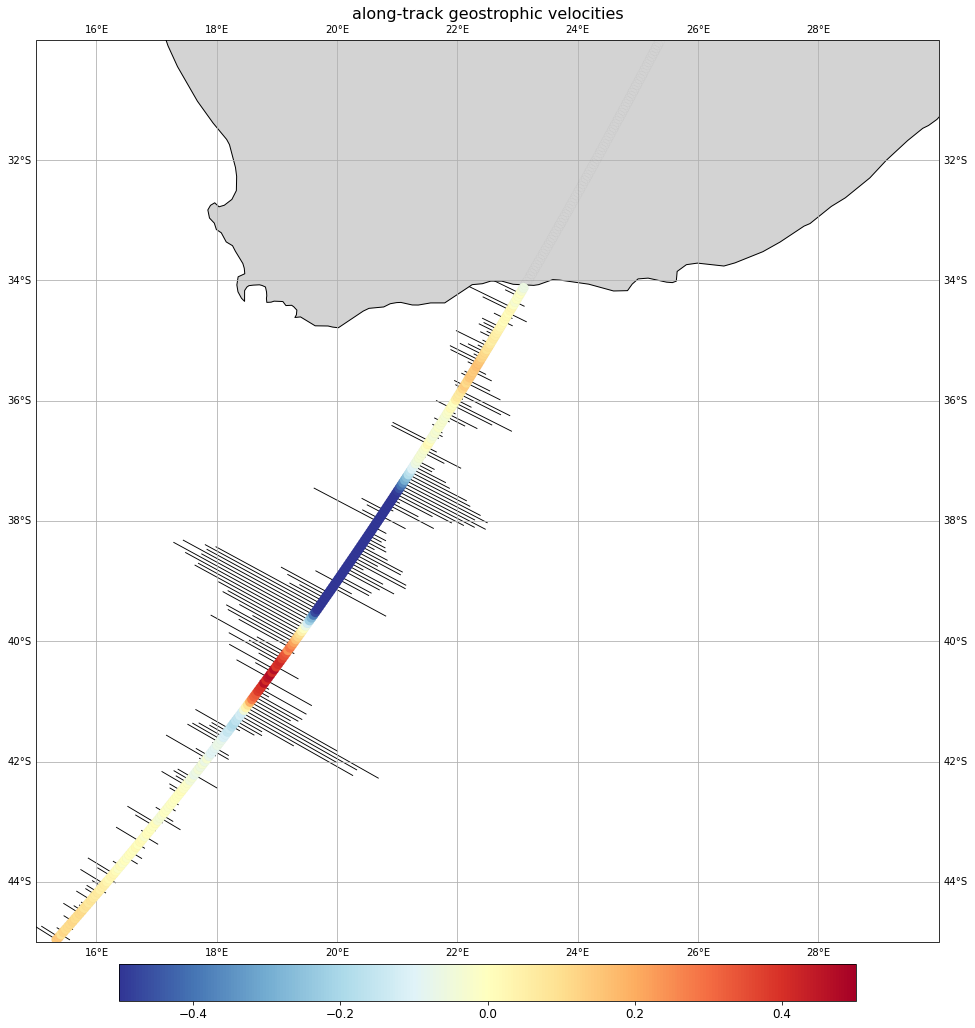

In [7]:
# eastward component
u = velocity*np.cos(angle_across_track)
# northward component
v = velocity*np.sin(angle_across_track)

# Create python object from the "matplotlib" and its "pyplot" package (shortened as plt)
plt.figure()
# Create an "ax" from which we add the projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.gridlines(draw_labels = True)
# Add a layer for the continent
land_hires = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor='lightgrey')
ax.add_feature(land_hires)
# Set the extent of the map
#ax.set_extent([-3, -1, 35, 37], crs=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
tracks = ax.scatter(lonextr, latextr, c=slaextr, vmin=hmin, vmax=hmax, alpha=1, cmap='RdYlBu_r', s=100, marker='o', edgecolors='black', linewidth=0.01, zorder=3)
Q = ax.quiver(lonextr[:-cwin], latextr[:-cwin], u, v, headwidth=0, headlength=0, headaxislength=0, scale=10, width=0.001)
# scale, norm=color_norm, width=width, units=units
#qk = ax.quiverkey(Q, 0.85, 0.1, 1, r'1$\frac{m}{s}$', labelpos='E', coordinates='figure', zorder=200)  
#plt.colorbar(Q, cax=cbar_ax, label="Velocity magnitude $(\mathrm{m~s}^{-1})$")
cbaralti = plt.colorbar(tracks, orientation="horizontal", shrink=0.66, pad=0.02)
cbaralti.ax.tick_params(labelsize=12)
# Add a title to the map object
plt.title('across-track geostrophic velocities', size=16)

Overlaid on a ChlA map for the same day

Text(0.5, 1.0, 'along-track geostrophic velocities')

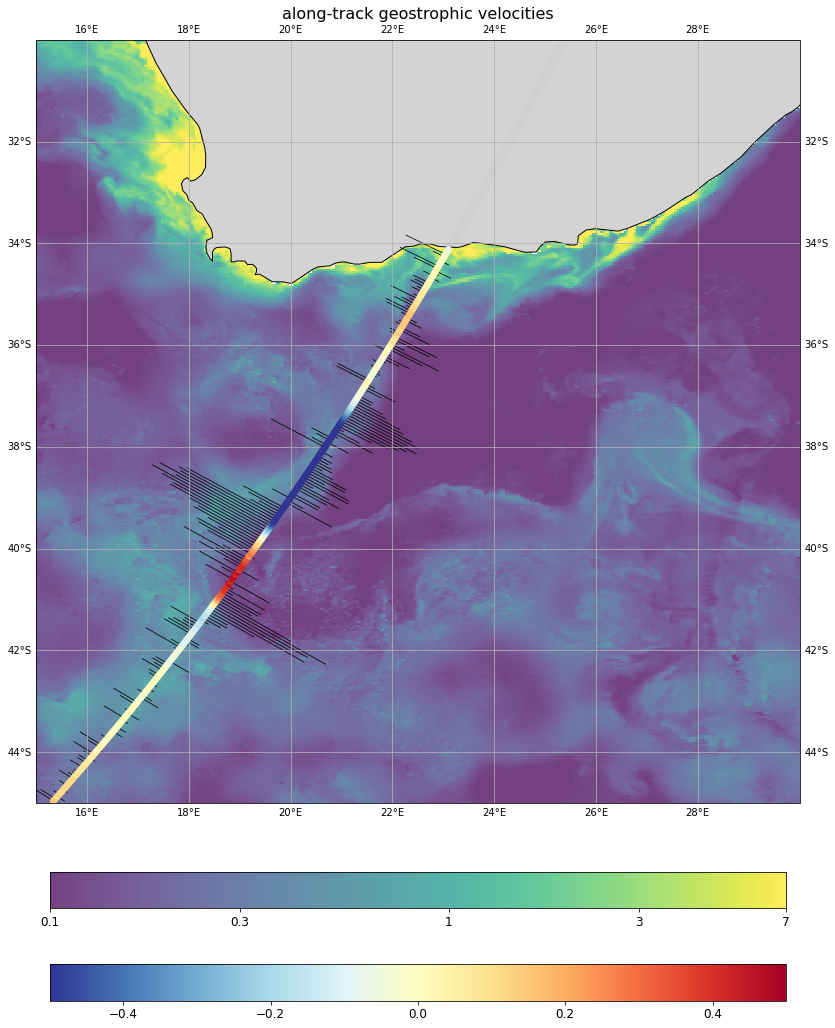

In [11]:
# ChlA map from Copernicus Marine Service
chla_file = '20220220_d-ACRI-L4-CHL-MULTI_4KM-GLO-DT.nc'
chlafile = os.path.join(input_root,input_path,chla_file)
ncchla = xr.open_dataset(chlafile)

latchla = ncchla['lat']
lonchla = ncchla['lon']
chla = ncchla['CHL'][0]
ncchla.close()

# Create python object from the "matplotlib" and its "pyplot" package (shortened as plt)
plt.figure()
# Create an "ax" from which we add the projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.gridlines(draw_labels = True)
# Add a layer for the continent
land_hires = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor='lightgrey')
ax.add_feature(land_hires)
# Set the extent of the map
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
chlamap = ax.pcolormesh(lonchla, latchla, np.squeeze(np.log10(chla)), vmin=np.log10(0.1), vmax=np.log10(7), cmap='viridis', alpha=0.75, zorder=1)
tracks = ax.scatter(lonextr, latextr, c=slaextr, vmin=hmin, vmax=hmax, alpha=1, cmap='RdYlBu_r', s=50, marker='o', edgecolors='black', linewidth=0.01, zorder=3)
Q = ax.quiver(lonextr[:-cwin], latextr[:-cwin], u, v, headwidth=0, headlength=0, headaxislength=0, scale=10, width=0.001, zorder=2)
#colorbars
cbaralti = plt.colorbar(tracks, orientation="horizontal", shrink=0.66, pad=-0.05)
cbarchla = plt.colorbar(chlamap, orientation="horizontal", shrink=0.66, pad=0.07, ticks=[np.log10(0.1), np.log10(0.3), np.log10(1), np.log10(3), np.log10(7)])
cbarchla.ax.set_xticklabels(['0.1','0.3','1','3','7'], fontsize=15) 
cbaralti.ax.tick_params(labelsize=12)
cbarchla.ax.tick_params(labelsize=12)
# Add a title to the map object
plt.title('along-track geostrophic velocities', size=16)

Alti L4 data, for comparison 

Text(0.5, 1.0, 'sla & current velocity')

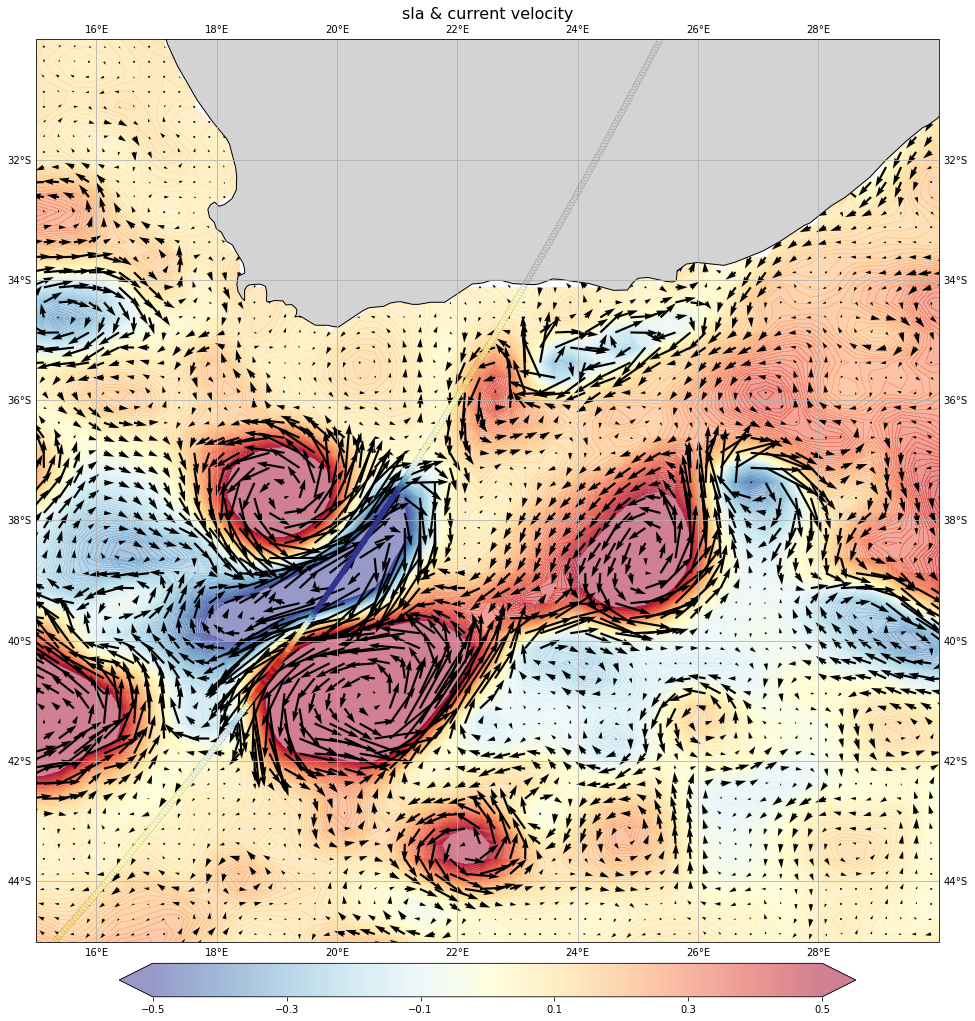

In [12]:
#checking with L4 geostrophic velocities
l4file = 'nrt_global_allsat_phy_l4_20220220_20220226.nc'
altil4file = os.path.join(input_root,input_path,l4file)
nc = xr.open_dataset(altil4file)

latl4 = nc['latitude']
lonl4 = nc['longitude']
slal4 = nc['sla'][0]
ul4 = nc['ugosa'][0]
vl4 = nc['vgosa'][0]
nc.close()

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.gridlines(draw_labels = True)
# map configuration
land_hires = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor='lightgrey')
ax.add_feature(land_hires)
ax.set_extent([lon_min, lon_max, lat_min, lat_max])

# plot the SLA as color and velocities as vectors
tracks = ax.scatter(lonextr, latextr, c=slaextr, vmin=hmin, vmax=hmax, cmap='RdYlBu_r', marker='o', edgecolors='black', linewidth=0.1, zorder=3)
mymap = ax.contourf(lonl4, latl4, slal4, levels=np.linspace(hmin,hmax,128), vmin=hmin, vmax=hmax, cmap='RdYlBu_r', extend='both', alpha=0.5)
arrows = ax.quiver(lonl4, latl4, ul4, vl4, scale=20.)

listeticks=np.linspace(hmin,hmax,6)
cbar = plt.colorbar(mymap, ax=ax, orientation='horizontal', pad=0.02, shrink=0.66, ticks=listeticks)
#cbar = plt.colorbar(colormesh, orientation="horizontal", shrink=0.66, pad=0.02)
# Add a title to the map object
plt.title('sla & current velocity', size=16)